full state
{'rooms': {0: array([[ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  0.,  0.,  0.,  1.],
       [ 1., -1.,  0.,  3.,  2.],
       [ 1.,  0.,  0.,  0.,  1.],
       [ 1.,  1.,  2.,  1.,  1.]]), 1: array([[1., 1., 1., 1., 1.],
       [1., 0., 0., 0., 1.],
       [2., 0., 0., 0., 1.],
       [1., 0., 0., 0., 1.],
       [1., 1., 2., 1., 1.]]), 2: array([[1., 1., 2., 1., 1.],
       [1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 2.],
       [1., 0., 0., 0., 1.],
       [1., 1., 1., 1., 1.]]), 3: array([[1., 1., 2., 1., 1.],
       [1., 0., 0., 0., 1.],
       [2., 0., 0., 0., 1.],
       [1., 0., 0., 0., 1.],
       [1., 1., 1., 1., 1.]])}, 'agent_room': 0, 'fruit_room': array([1., 0., 0., 0.])}
flatten state
[ 1.  1.  1.  1.  1.  1.  0.  0.  0.  1.  1. -1.  0.  3.  2.  1.  0.  0.
  0.  1.  1.  1.  2.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  1.  2.
  0.  0.  0.  1.  1.  0.  0.  0.  1.  1.  1.  2.  1.  1.  1.  1.  2.  1.
  1.  1.  0.  0.  0.  1.  1.  0.  0.  0.  2.  1.  0.  0.  0.  1

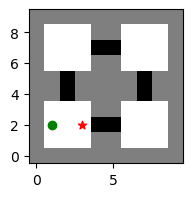

In [37]:
import numpy as np
from utils.environments import NRoomsZanin
env = NRoomsZanin(room_shapes=(5, 5), grid_shape=(2,2), n_doors=1, start_agent_pos=(0,None,None),start_fruits_pos=[(0,None,None)])
state, info = env.reset()
env.render()

print("full state")
print(env.current_state)

print("flatten state")
print(env.observation_space.flatten_obs(env.current_state))

In [38]:
from utils.concepts import ConditionalStripFieldConcept, StripFieldConcept

concepts = [
    ConditionalStripFieldConcept("rooms", "agent_room", env.observation_space),
    StripFieldConcept("agent_room", env.observation_space),
    StripFieldConcept("fruit_room", env.observation_space),
]

In [39]:
def flatten_concept(concept, state):
    return concept.output_observation_space.flatten_obs(concept(state))

for concept in concepts:
    print("CONCEPT NAME:", concept.name)
    print("OBSERVATION SPACE:", concept.output_observation_space)
    print("SAMPLE OUTPUT\n",concept(env.current_state))
    print("flattened:", flatten_concept(concept, env.current_state))
    print()

CONCEPT NAME: Strip[rooms][agent_room]Concept
OBSERVATION SPACE: TensorSpace(shape=(5, 5))
SAMPLE OUTPUT
 [[ 1.  1.  1.  1.  1.]
 [ 1.  0.  0.  0.  1.]
 [ 1. -1.  0.  3.  2.]
 [ 1.  0.  0.  0.  1.]
 [ 1.  1.  2.  1.  1.]]
flattened: [ 1.  1.  1.  1.  1.  1.  0.  0.  0.  1.  1. -1.  0.  3.  2.  1.  0.  0.
  0.  1.  1.  1.  2.  1.  1.]

CONCEPT NAME: Strip[agent_room]Concept
OBSERVATION SPACE: FiniteSpace([0, 1, 2, 3])
SAMPLE OUTPUT
 0
flattened: [1. 0. 0. 0.]

CONCEPT NAME: Strip[fruit_room]Concept
OBSERVATION SPACE: TensorSpace(shape=(4,))
SAMPLE OUTPUT
 [1. 0. 0. 0.]
flattened: [1. 0. 0. 0.]



In [42]:
from utils.dynamicpolicies import DiscretePolicyMapperFactory
from utils.policies import DiscreteQnetPolicyFactory, FlattenSpacePolicyAdapterFactory
from utils.neuralnetworks import OptimizableLinearNetFactory

intra_layer_policy_factory = DiscretePolicyMapperFactory(
    FlattenSpacePolicyAdapterFactory(
        DiscreteQnetPolicyFactory(OptimizableLinearNetFactory(Nh=(16,)))
    )
)

In [43]:
from utils.mango import Mango
from utils.compatibilityfunctions import (
    FullCompatibility,
    GridAdjacencyCompatibility,
    MultiConceptCompatibilityAdapter,
)

# create a concepts from top to bottom

abstract_concept2 = StripFieldConcept("fruit_room", env.observation_space)
compatibility2 = FullCompatibility(
    FiniteSpace(["prendi frutto"]),
    abstract_concept2.output_observation_space,
    default_val=0.05,
)

abstract_concept1 = StripFieldConcept("agent_room", env.observation_space)
local_compatibility1 = GridAdjacencyCompatibility(abstract_concept1.output_observation_space, env.grid_shape)  # type: ignore
compatibility1 = MultiConceptCompatibilityAdapter(
    {
        abstract_concept1.name: local_compatibility1,
        abstract_concept2.name: compatibility2,
    },
    default_val=-0.05,
)

base_concept = ConditionalStripFieldConcept(
    "rooms", "agent_room", env.observation_space
)

mango = Mango(
    environment=env,  # type: ignore
    base_concept=base_concept,
    concept_functions=[abstract_concept1, abstract_concept2],
    compatibility_functions=[compatibility1, compatibility2],
    dynamic_policy_factories=[intra_layer_policy_factory, intra_layer_policy_factory],
)

In [45]:
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import snakeviz
%load_ext snakeviz

The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz


{'Strip[agent_room]Concept': 0, 'Strip[fruit_room]Concept': array([1., 0., 0., 0.])}
{'Strip[agent_room]Concept': 0, 'Strip[fruit_room]Concept': array([0., 0., 0., 0.])}


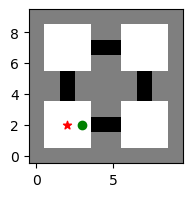

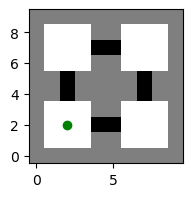

In [51]:
mango.reset(how = "base")
print(mango.layers[1].observation_buffer.current_observation)
env.render()
mango.layers[1].step("L")
print(mango.layers[1].observation_buffer.current_observation)
env.render()
env.reset_trace()

In [52]:
#%%snakeviz -t
rewards = []
for i in tqdm(range(100)):
    mango.layers[-1].reset(how = "base")
    mango.layers[1].step("prendi frutto")
    mango.layers[1].train()


  0%|          | 0/100 [00:00<?, ?it/s]

In [53]:
rewards = []
for i in tqdm(range(100)):
    mango.layers[-1].reset(how = "random")
    mango.layers[2].step("prendi frutto")
    mango.layers[2].train()


  0%|          | 0/500 [00:00<?, ?it/s]

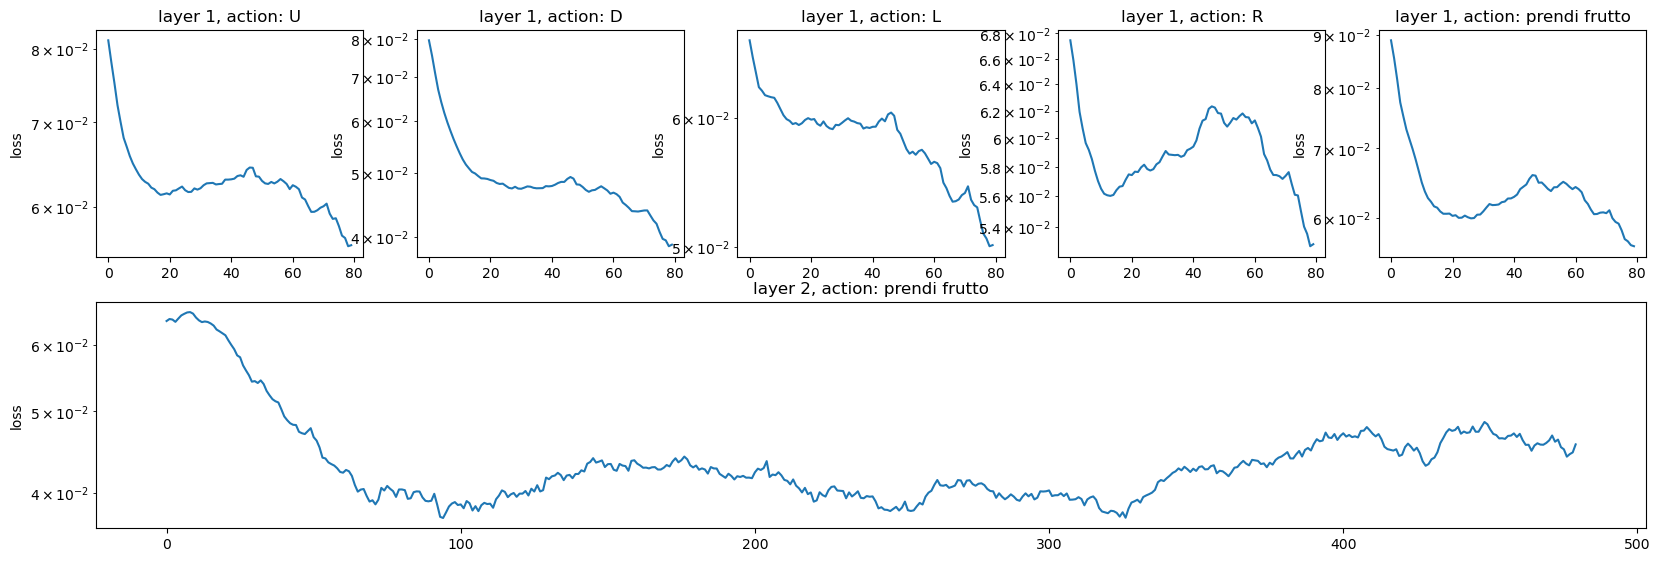

In [54]:
plt.figure(figsize=(20,10))
for i, layer in enumerate(mango.layers[1:]):
    for j, action in enumerate(layer.action_space):
        loss_log = layer.intra_layer_policy.policy_map[action].flat_policy.loss_log_roll_mean
        plt.subplot(len(mango.layers),len(layer.action_space),i*len(layer.action_space)+j+1)
        plt.semilogy(loss_log)
        plt.ylabel("loss")
        plt.title(f"layer {i+1}, action: {action}")

ACTION D || ENV REWARD 0.0
INTRINSIC REWARD {'U': -0.05, 'D': -0.05, 'L': -0.05, 'R': -0.05, 'prendi frutto': -0.05}
ACTION D || ENV REWARD 0.0
INTRINSIC REWARD {'U': -0.05, 'D': -0.05, 'L': -0.05, 'R': -0.05, 'prendi frutto': -0.05}
ACTION L || ENV REWARD 0.0
INTRINSIC REWARD {'U': -0.05, 'D': -0.05, 'L': -0.05, 'R': -0.05, 'prendi frutto': -0.05}
ACTION D || ENV REWARD -0.1
INTRINSIC REWARD {'U': -0.05, 'D': -0.05, 'L': -0.05, 'R': -0.05, 'prendi frutto': -0.05}
ACTION R || ENV REWARD 0.0
INTRINSIC REWARD {'U': -0.05, 'D': -0.05, 'L': -0.05, 'R': -0.05, 'prendi frutto': -0.05}
ACTION L || ENV REWARD 0.0
INTRINSIC REWARD {'U': -0.05, 'D': -0.05, 'L': -0.05, 'R': -0.05, 'prendi frutto': -0.05}
ACTION R || ENV REWARD 0.0
INTRINSIC REWARD {'U': -0.05, 'D': -0.05, 'L': -0.05, 'R': -0.05, 'prendi frutto': -0.05}
ACTION U || ENV REWARD 0.0
INTRINSIC REWARD {'U': -0.05, 'D': -0.05, 'L': -0.05, 'R': -0.05, 'prendi frutto': -0.05}
ACTION L || ENV REWARD 0.0
INTRINSIC REWARD {'U': -0.05, 'D': -

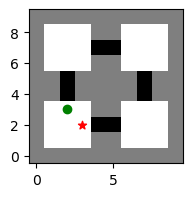

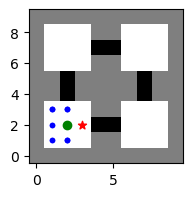

In [68]:
mango.reset(how = "base")
env.render()
mango.layers[1].set_exploration_rate(0.0)

mango.layers[1].step("prendi frutto", verbose = True)

env.render()


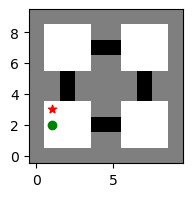

In [69]:
mango.reset(how = "base")
env.render()
mango.layers[1].set_exploration_rate(0.0)

ACTION U || ENV REWARD 0.0
INTRINSIC REWARD {'U': -1.0, 'D': -1.0, 'L': -1.0, 'R': -1.0, 'prendi frutto': 1.0}
iteration_length:  1


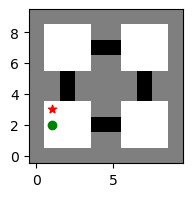

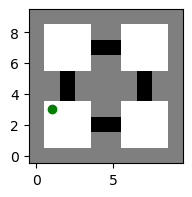

In [70]:
env.render()
mango.layers[1].step("U", verbose = True)
env.render()

In [80]:
sasri = mango.layers[1].replay_memory.memory[mango.layers[1].replay_memory.index-1]
print(sasri.reward, sasri.info)
for comand in mango.layers[1].action_space:
    print(comand, mango.layers[1].reward_generator.generate_reward(comand, sasri).reward)


0.0 {'buffertransition': ({'Strip[agent_room]Concept': 0, 'Strip[fruit_room]Concept': array([1., 0., 0., 0.])}, {'Strip[agent_room]Concept': 0, 'Strip[fruit_room]Concept': array([0., 0., 0., 0.])})}
U -1.0
D -1.0
L -1.0
R -1.0
prendi frutto 1.0
